In [701]:
# ======================================================
# Project: Food Collector
# Authors: Gamaliel Marines Olvera A01708746
#          Juan Pablo Cabrera Quiroga
#          Sebastian Flores  Lemus A01709229
# Description: This script contains the implementation
#              of the Food Collector simulation and 
#              the server that allows the communication
#              between the simulation and the Unity
#              application.
# ======================================================

In [702]:
# ======================================================
# Imports
# ======================================================

from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# from matplotlib.colors import ListedColormap

plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import random
random.seed(12345)

from http.server import BaseHTTPRequestHandler, HTTPServer
import logging
import json

import pandas as pd
import math



In [703]:
#=============================================
# Deposit Agent
#=============================================

class DepositAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.type = 1
        self.visible = False
        self.collected_food_count = 0 

    def add_food(self):
        self.collected_food_count += 1

In [704]:
#=============================================
# Food Agent
#=============================================

class FoodAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.type = 2
        self.deposited = False

In [705]:
#=============================================
# Carrier Agent
#=============================================
class RobotAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.type = 3
        self.role = "explorer"
        self.carrying_food = False
        self.deposit_pos = None
        self.food_positions = []
        self.agent_visited_positions = []

    def moveRandom(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False)
        possible_steps = [step for step in possible_steps if self.model.grid.is_cell_empty(
            step) or self.contains_food(step) or self.contains_deposit(step)]

        if possible_steps:
            new_position = random.choice(possible_steps)
            self.model.grid.move_agent(self, new_position)

    def contains_food(self, pos):
        cell_contents = self.model.grid.get_cell_list_contents(pos)
        return any(isinstance(content, FoodAgent) for content in cell_contents)

    def contains_deposit(self, pos):
        cell_contents = self.model.grid.get_cell_list_contents(pos)
        return any(isinstance(content, DepositAgent) for content in cell_contents)

    def explore(self):
        self.moveRandom()

    def collect(self):
        if self.carrying_food:
            self.move2warehouse()
        else:
            self.move2food()

    def communicate_food_position(self, food_position):
        if food_position not in self.model.known_food_positions:
            self.model.known_food_positions.append(food_position)
        self.food_positions = self.model.known_food_positions

    def communicate_deposit_position(self, deposit_position):
        if self.model.known_deposit_pos is None:
            self.model.known_deposit_pos = deposit_position
        self.deposit_pos = self.model.known_deposit_pos

    def change_role_to_collector(self):
        if self.model.num_collectors < 2 and self.role == "explorer" and self.model.known_deposit_pos is not None:
            self.role = "collector"
            self.model.num_collectors += 1
            print(f"{self.unique_id} became a collector")

    def move2food(self):
        if not self.carrying_food and self.food_positions:
            food_target = min(self.food_positions, key=lambda pos: self.distance_to(pos))
            self.move_towards(food_target)
            print(f"agent {self.unique_id} moved to food {food_target}")
            self.pickup_food()
        else:
            self.moveRandom()

    def move_towards(self, target_pos):
        x_dir = target_pos[0] - self.pos[0]
        y_dir = target_pos[1] - self.pos[1]

        possible_steps = []
        if x_dir != 0:
            possible_steps.append(
                (self.pos[0] + (1 if x_dir > 0 else -1), self.pos[1]))
        if y_dir != 0:
            possible_steps.append(
                (self.pos[0], self.pos[1] + (1 if y_dir > 0 else -1)))

        valid_steps = [
            step for step in possible_steps if self.model.grid.is_cell_empty(step) or self.contains_deposit(step) or self.contains_food(step)]
        if valid_steps:
            next_step = min(
                valid_steps, key=lambda step: self.distance_to(step))
            self.model.grid.move_agent(self, next_step)

    def distance_to(self, target_pos):
        return abs(self.pos[0] - target_pos[0]) + abs(self.pos[1] - target_pos[1])
    
    def move2warehouse(self):
        # print(f"agent {self.unique_id} is moving to warehouse")
        # print(f"Deposit Pos {self.deposit_pos}")
        self.move_towards(self.deposit_pos)
        # print(f"Agent pos {self.pos}")
        if self.pos == self.deposit_pos:
            self.dropfood()

    def pickup_food(self):
        cell_contents = self.model.grid.get_cell_list_contents(self.pos)
        food = next((obj for obj in cell_contents if isinstance(obj, FoodAgent) and not obj.deposited), None)
        if food:
            self.carrying_food = True
            food.deposited = True  
            self.remove_food_from_cell()  
            if self.pos in self.food_positions:
                self.food_positions.remove(self.pos)  

            print(f"agent {self.unique_id} picked up food at {self.pos}")
            self.move2warehouse()

    def remove_food_from_cell(self):
        if self.carrying_food:
            cell_contents = self.model.grid.get_cell_list_contents(self.pos)
            food = next((obj for obj in cell_contents if isinstance(obj, FoodAgent)), None)
            if food:
                self.model.grid.remove_agent(food)
                print(f"Food removed from {self.pos} by agent {self.unique_id}")

    def dropfood(self):
        print(f"{self.unique_id} dropped food")
        self.carrying_food = False
        deposit = next(obj for obj in self.model.grid.get_cell_list_contents(self.pos) if isinstance(obj, DepositAgent))
        deposit.add_food()

    def step(self):
        if self.role == "explorer":
            current_cell_contents = self.model.grid.get_cell_list_contents([self.pos])
            for content in current_cell_contents:

                if self.model.known_deposit_pos is not None:
                    self.change_role_to_collector() 

                else: 
                    if isinstance(content, DepositAgent) and self.model.known_deposit_pos is None:
                        self.communicate_deposit_position(self.pos)

                if isinstance(content, FoodAgent) and self.pos not in self.model.known_food_positions:
                    self.communicate_food_position(self.pos)

            self.explore()

        elif self.role == "collector":
            if not self.carrying_food:
                if self.food_positions:
                    if self.pos in self.food_positions:
                        self.pickup_food()
                    else:
                        self.move2food()
            elif self.carrying_food:
                if self.pos == self.deposit_pos:
                    self.dropfood()
                else:
                    self.move2warehouse()

        self.deposit_pos = self.model.known_deposit_pos
        self.food_positions = self.model.known_food_positions

        # print(f"{self.unique_id} {self.carrying_food}")

        # print(f"Deposit position: {self.deposit_pos}")
        print(f"Food length Robot Agent {self.food_positions}")

In [706]:
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for content, (x, y) in model.grid.coord_iter():
        cell_value = 0
        for agent in content:
            if isinstance(agent, DepositAgent):
                cell_value = 4 
            elif isinstance(agent, FoodAgent):
                cell_value = 2
            elif isinstance(agent, RobotAgent):
                cell_value = 3
                if agent.role == "collector":
                    cell_value = 1
                    if agent.carrying_food:
                        cell_value = 5

        grid[x][y] = cell_value
    return grid

In [707]:
# Food Collector Model Class
# ======================================================
class FoodCollector(Model):
    # ==============================================================
    # Function: __init__
    # Description: Initializes the food collector model.
    # Parameters:  width: The width of the grid.
    #              height: The height of the grid.
    #              map: The map of the simulation.
    #              num_robots: The number of robots in the simulation.
    # Return:None
    # ==============================================================
    def __init__(self, width, height, num_agents):
        self.grid = MultiGrid(width, height, torus = False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid" : get_grid})
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.food_id = 7
        self.steps = 0
        self.food_counter = 0    # Contador de comida en el campo
        self.known_food_positions = []
        self.known_deposit_pos = None
        self.num_collectors = 0

        self.crear_agentes()

    def crear_agentes(self):
        agent_id = 1

        # Colocar Deposit
        deposit = DepositAgent(0, self)
        self.schedule.add(deposit)
        pos = self.random_empty_cell()
        self.grid.place_agent(deposit, pos)

        # Colocar los robots
        for _ in range(self.num_agents):
            robot = RobotAgent(agent_id, self)
            self.schedule.add(robot)
            pos = self.random_empty_cell()
            self.grid.place_agent(robot, pos)
            agent_id += 1
            # print(f"Adding {agent_id} at step {self.steps}.")

    def add_food(self):
        if self.food_counter < 47:
            num_new_food = random.randint(2, 5)

            # print(f"Adding {num_new_food} new food items at step {self.steps}.")

            for _ in range(num_new_food):
                if self.food_counter < 47:
                    food = FoodAgent(self.food_id, self)
                    self.schedule.add(food)
                    pos = self.random_empty_cell()
                    self.grid.place_agent(food, pos)
                    self.food_counter += 1
                    self.food_id += 1

            # print(f"Total food items: {self.food_counter} at {pos}")

    def random_empty_cell(self):
        empty_cells = [(x, y) for x in range(self.width) for y in range(self.height) if self.grid.is_cell_empty((x, y))]
        if not empty_cells:
            raise Exception("No empty cells available.")
        return random.choice(empty_cells)
    
    def broadcast_food_positions(self):
        for agent in self.schedule.agents:
            if isinstance(agent, RobotAgent):
                agent.food_positions = self.known_food_positions

    def all_food_placed(self):
        for agent in self.schedule.agents:
            if isinstance(agent, DepositAgent) and agent.collected_food_count >= 47:
                return True
        return False

    def step(self):
        if self.all_food_placed():
            print(f"Objetivo alcanzado: 47 comidas recolectadas.")
            return

        if self.steps % 5 == 0 and self.steps >= 5:
            self.add_food()
                    
        self.schedule.step()
        self.datacollector.collect(self) 
        self.steps += 1

In [708]:
WIDTH = 20
HEIGHT = 20
NUM_AGENTS = 5

MAX_STEPS = 1500

model = FoodCollector(WIDTH, HEIGHT, NUM_AGENTS)

for i in range(MAX_STEPS + 1):
    model.step()
    if model.all_food_placed():
        print(f'Pasos totales para alcanzar el objetivo: {model.steps}')
        break


data = model.datacollector.get_model_vars_dataframe()

Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
Food length Robot Agent []
F

In [709]:
all_grid = model.datacollector.get_model_vars_dataframe()

/var/folders/f0/_1kmynrd62zdz552kgfzq_9w0000gn/T/ipykernel_55992/751325584.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(all_grid.iloc[0][0], cmap="terrain", vmin=0, vmax=6)
/var/folders/f0/_1kmynrd62zdz552kgfzq_9w0000gn/T/ipykernel_55992/751325584.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grid.iloc[i][0])


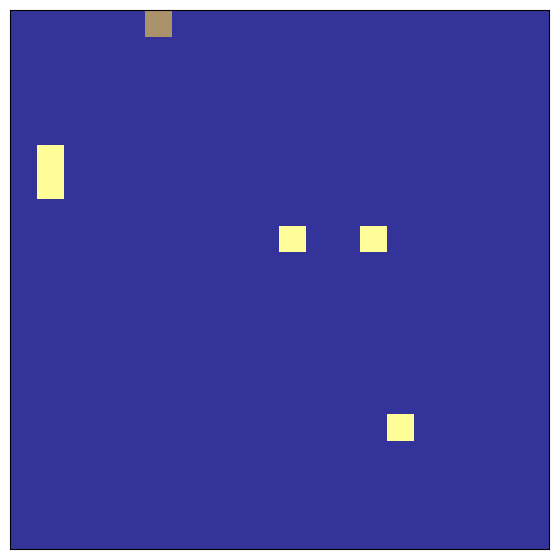

In [710]:
fig, axs = plt.subplots(figsize=(7, 7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap="terrain", vmin=0, vmax=6)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=len(all_grid))


In [711]:
anim

/var/folders/f0/_1kmynrd62zdz552kgfzq_9w0000gn/T/ipykernel_55992/751325584.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grid.iloc[i][0])
